## US Election 2020 Twitter Sentiment Analysis

There are plenty of existing population polls trying to predict the outcome of a Presidential election. It would be of interest to perform ML sentiment analysis of a sample of past Twitter feeds (before it became X) to see how accurate it would be. Of course it begs the question if the sample population in Twitter has a diverse representation. On the other hand, the same can be said of the traditional polls and whether their samples are also diverse.

#### Dataset
I am using the [US Election 2020 Sample Dataset](https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets/data) from Kaggle for this analysis. It consists of two CSV files totaling about 1.7 million rows, one with Tweets focused on Joe Biden, and the other on Donald Trump. The dataset needs to be culled of Tweets originating outside of the US. While that doesn’t guarantee that non-US citizens in the US are Tweeting (or that citizens outside of the US are Tweeting) it helps narrow down any international opinions that would skew the results. The rest would be just data cleaning, for example, removing hashtags/mentions, URLs, and any extraneous text that is not generally readable and that may not convert to useful tokens. However, there some tools exist to help with data cleaning as well.

#### Tools
As of late there are several publicly available LLMs that can assist with sentiment analysis, specifically on Twitter/X data. I'd like to explore the use of Hugging Face's [Twitter roBERTa-base Sentiment Analysis module](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest). Additionally, the [distilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) and [sieBERT](https://huggingface.co/siebert/sentiment-roberta-large-english) models will be compared as well.

In [52]:
# Import Libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import plotly.express as px
import re   # regex for data cleaning
from tqdm import tqdm    # Shows progress bar for long tasks
from google.colab import drive
from sklearn.metrics import cohen_kappa_score

---
## Analyzing results from multiple sentiment models

I have run the election dataset through the three sentiment analysis models above: roBERTa, distilBERT, and sieBERT, and save each output DF to a CSV so we don't have to keep rerunning the models.

#### Reading in results


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Read in various model results
roberta_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/results/tweetUSA_sentiment_roBERTa.csv",
    lineterminator='\n',
    header=0,
    index_col=0,
    dtype={"city": str, "state": str, "state_code": str},
    low_memory=False
)

distilbert_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/results/tweetUSA_sentiment_distilBERT.csv",
    lineterminator='\n',
    header=0,
    index_col=0,
    dtype={"city": str, "state": str, "state_code": str},
    low_memory=False
)

sieb_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/results/tweetUSA_sentiment_siebert.csv",
    lineterminator='\n',
    header=0,
    index_col=0,
    dtype={"city": str, "state": str, "state_code": str},
    low_memory=False
)

Cleaning up the data a little and make sure data formats match.

In [31]:
roberta_df.columns = roberta_df.columns.str.strip()
distilbert_df.columns = distilbert_df.columns.str.strip()
sieb_df.columns = sieb_df.columns.str.strip()

In [41]:
roberta_df['sentiment']= roberta_df['sentiment'].str.lower()
distilbert_df['sentiment']= distilbert_df['sentiment'].str.lower()
sieb_df['sentiment']= sieb_df['sentiment'].str.lower()

---
#### Prepare for meta-analysis

Add a column to differentiate tweet sentiments for each model before we combine them.

In [45]:
# Add a model identifier to each DataFrame
roberta_df['model'] = 'roBERTa'
distilbert_df['model'] = 'DistilBERT'
sieb_df['model'] = 'sieBERT'

In [46]:
# Concatenate all results into one DataFrame
all_df = pd.concat([roberta_df, distilbert_df, sieb_df], ignore_index=True)

---
#### Show absolute aggregate tweet counts

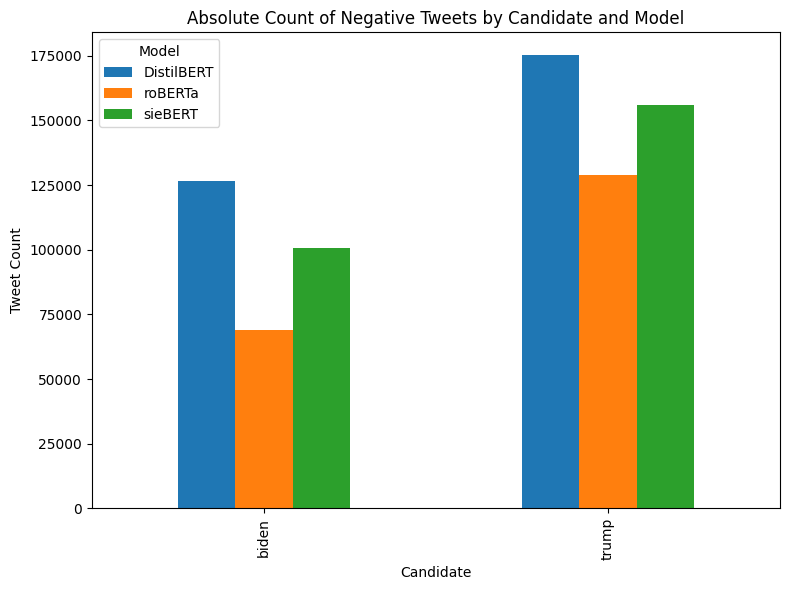

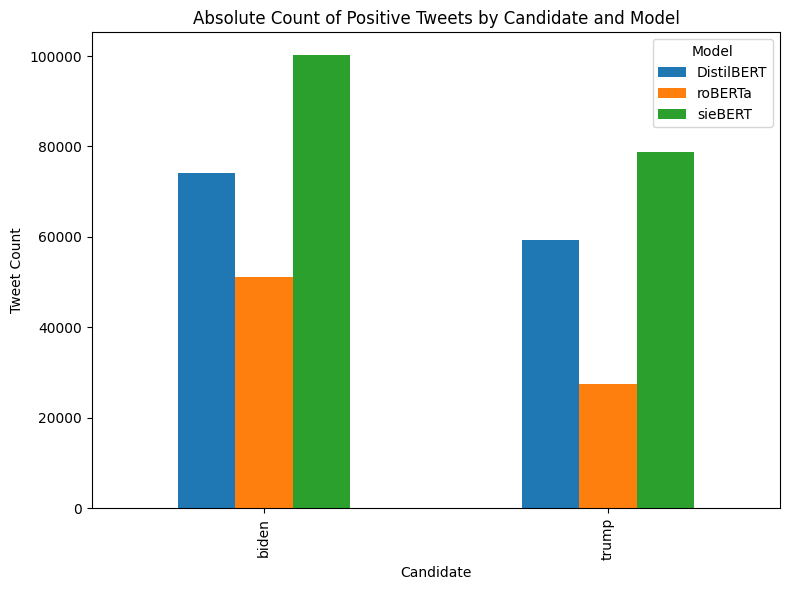

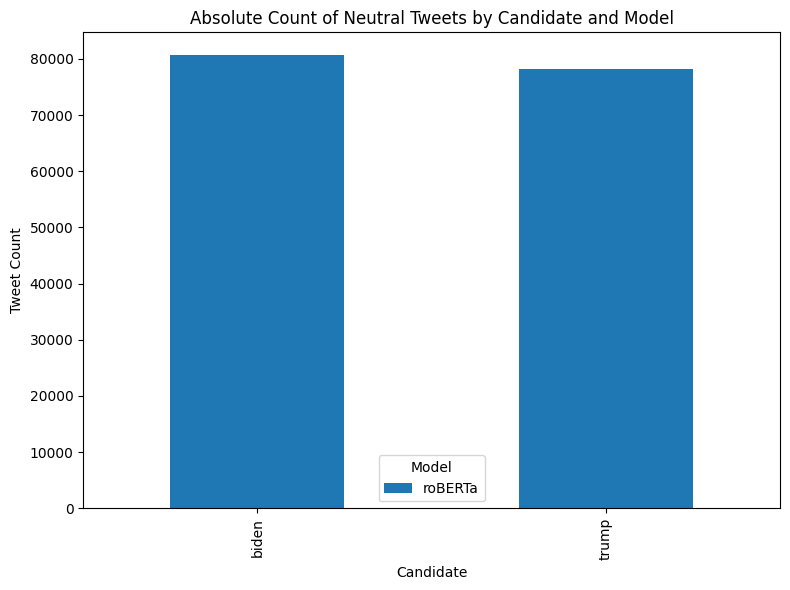

In [47]:
# Group the data: count of tweets by candidate, model, and sentiment.
aggregated = all_df.groupby(['candidate', 'model', 'sentiment'])\
                   .size().reset_index(name='count')

# Determine the unique sentiment categories
sentiments = aggregated['sentiment'].unique()

# Plot a unified chart for each sentiment category
for sentiment in sentiments:
    data_sentiment = aggregated[aggregated['sentiment'] == sentiment]
    # Pivot to get candidates as index and models as columns
    pivot = data_sentiment.pivot(index='candidate',
                                 columns='model',
                                 values='count').fillna(0)

    # Create a grouped bar chart for this sentiment
    ax = pivot.plot(kind='bar', figsize=(8, 6))
    ax.set_title(f"Absolute Count of {sentiment.capitalize()} Tweets by Candidate and Model")
    ax.set_xlabel("Candidate")
    ax.set_ylabel("Tweet Count")
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

#### Show normalized tweet counts by candidate and model

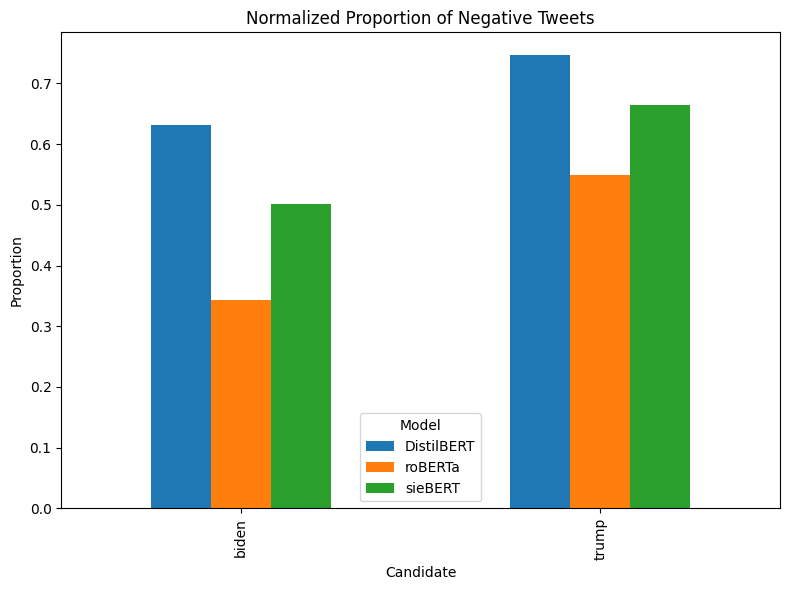

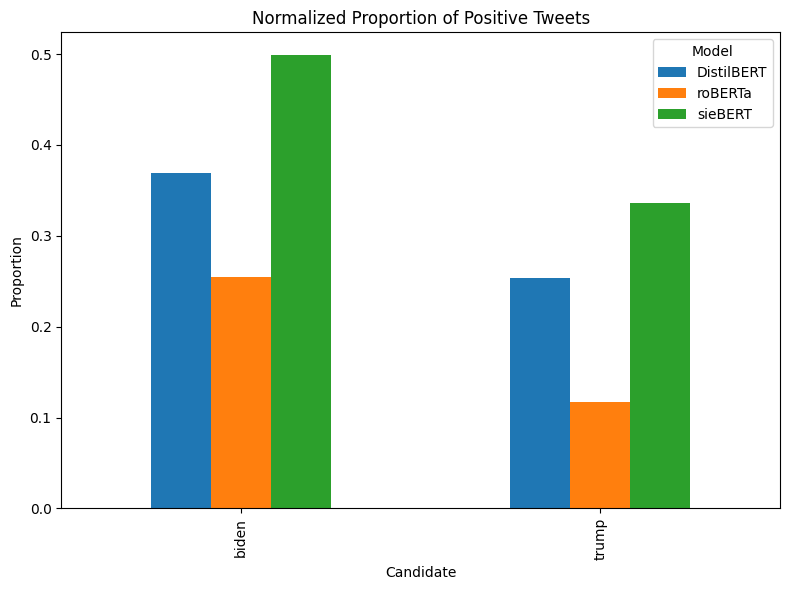

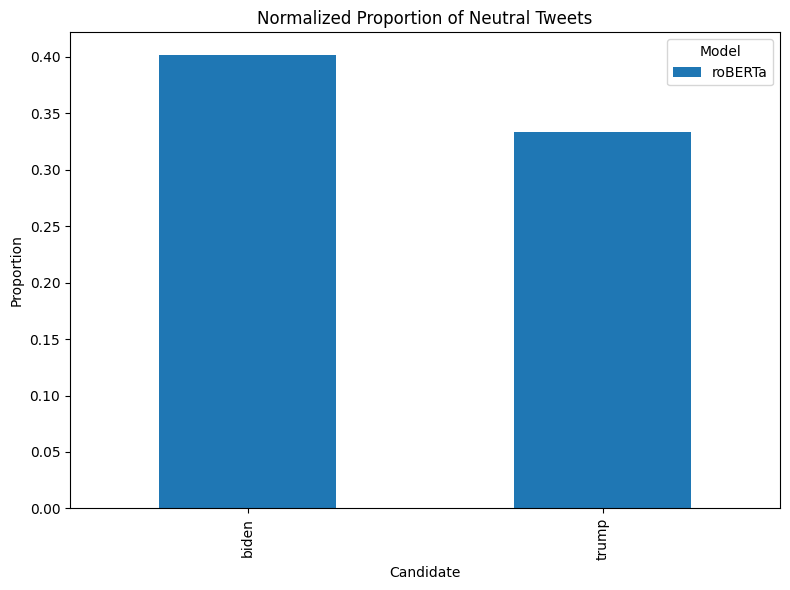

In [48]:
# Compute counts per candidate, model, and sentiment (as before)
aggregated = all_df.groupby(['candidate', 'model', 'sentiment'])\
                   .size()\
                   .reset_index(name='count')

# Compute total tweets per candidate and model
totals = aggregated.groupby(['candidate', 'model'])['count']\
                   .sum()\
                   .reset_index(name='total')

# Merge totals back into the aggregated DataFrame and compute proportions
aggregated = aggregated.merge(totals, on=['candidate', 'model'])
aggregated['proportion'] = aggregated['count'] / aggregated['total']

# Again, determine sentiment categories
sentiments = aggregated['sentiment'].unique()

# Plot normalized (proportional) counts for each sentiment category
for sentiment in sentiments:
    data_sentiment = aggregated[aggregated['sentiment'] == sentiment]
    pivot = data_sentiment.pivot(index='candidate',
                                 columns='model',
                                 values='proportion').fillna(0)

    ax = pivot.plot(kind='bar', figsize=(8, 6))
    ax.set_title(f"Normalized Proportion of {sentiment.capitalize()} Tweets")
    ax.set_xlabel("Candidate")
    ax.set_ylabel("Proportion")
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

#### Plot the normalized tweet counts by confidence levels in each model.

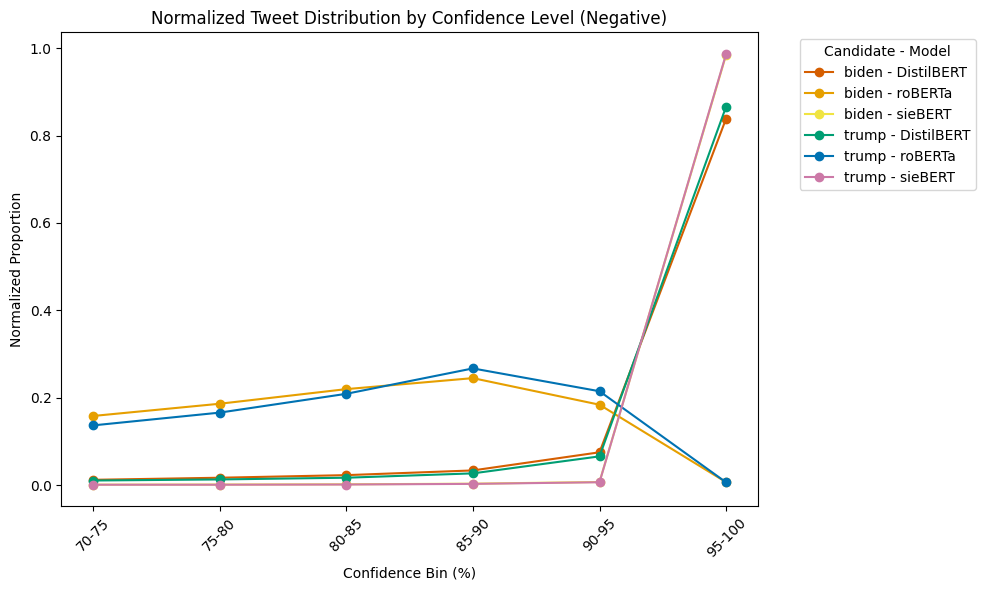

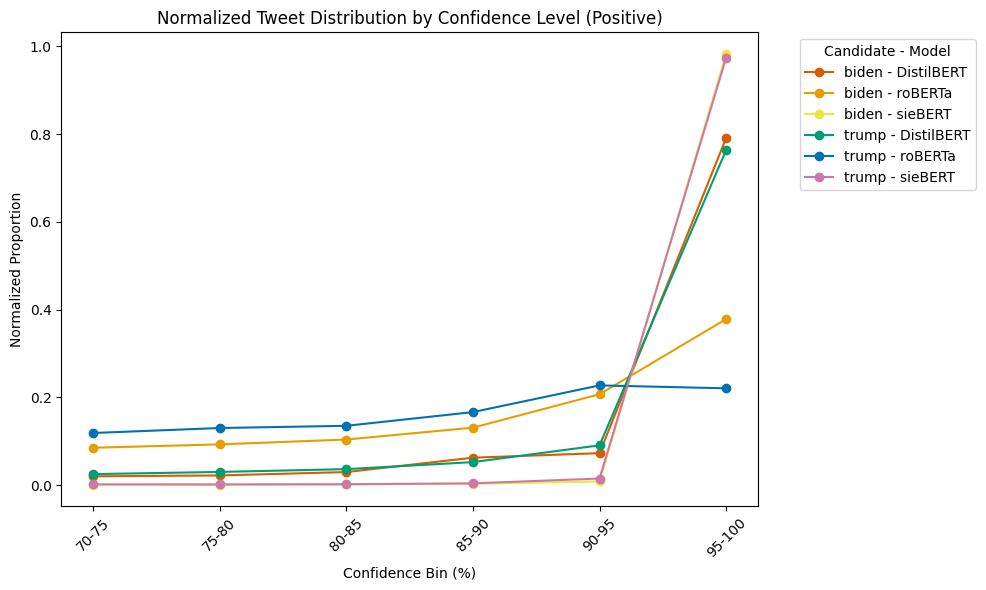

In [64]:
# Define confidence bins (from 70% to 100% in 5% increments)
bins = np.arange(0.70, 1.01, 0.05)
labels = [f"{int(bins[i]*100)}-{int(bins[i+1]*100)}" \
          for i in range(len(bins)-1)]

def plot_normalized_distribution_combined(df, bins, labels):
    # Filter for rows with clearly defined sentiments (positive or negative)
    df_filtered = df[df['sentiment'].isin(['positive', 'negative'])].copy()

    # Bin the sentiment_score values into the defined confidence ranges
    df_filtered['confidence_bin'] = pd.cut(
        df_filtered['sentiment_score'],
        bins=bins,
        labels=labels,
        right=False
    )

    # Group by candidate, model, sentiment, and confidence bin and count tweets
    grouped = (
        df_filtered
        .groupby(['candidate', 'model', 'sentiment', 'confidence_bin'],
                 observed=True)
        .size()
        .reset_index(name='count')
    )

    # Normalize: for each candidate-model-sentiment group,
    # compute the proportion per confidence bin
    grouped['total'] = grouped.groupby(['candidate',
                                        'model',
                                        'sentiment'])['count'].transform('sum')
    grouped['proportion'] = grouped['count'] / grouped['total']

    # Create a new column that combines candidate and
    # model for easier differentiation
    grouped['cand_model'] = grouped['candidate'] + " - " + grouped['model']

    # Set up a high contrast color palette for the lines
    high_contrast_palette = ["#D55E00",
                             "#E69F00",
                             "#F0E442",
                             "#009E73",
                             "#0072B2",
                             "#CC79A7"]
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=high_contrast_palette)

    # For each sentiment, pivot the data so that rows are confidence bins and
    # columns are cand_model, then plot the normalized proportions as a line chart.
    for sentiment in grouped['sentiment'].unique():
        subset = grouped[grouped['sentiment'] == sentiment]
        pivot = subset.pivot(index='confidence_bin',
                             columns='cand_model',
                             values='proportion')
        pivot = pivot.sort_index()  # Ensure the confidence bins are in order

        ax = pivot.plot(marker='o', figsize=(10, 6), kind='line')
        ax.set_title(f"Normalized Tweet Distribution by Confidence Level ({sentiment.capitalize()})")
        ax.set_xlabel("Confidence Bin (%)")
        ax.set_ylabel("Normalized Proportion")
        plt.xticks(rotation=45)
        plt.legend(title='Candidate - Model',
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left')
        plt.tight_layout()
        plt.show()

plot_normalized_distribution_combined(all_df, bins, labels)

### Additonal Meta-analyses

Pre-process data to make "fair" analysis

In [53]:
# Filter out neutrals and drop rows with sentiment_score below 0.8
filtered_df = all_df[(all_df['sentiment'] != 'neutral') & \
                     (all_df['sentiment_score'] >= 0.8)].copy()

In [54]:
df_roberta     = filtered_df[filtered_df['model'] == 'roBERTa']
df_distilbert  = filtered_df[filtered_df['model'] == 'DistilBERT']
df_sieb        = filtered_df[filtered_df['model'] == 'sieBERT']

#### Intermodel Agreement Analysis

In [55]:
# Merge predictions on tweet_id between roBERTa and DistilBERT
merge_rd = df_roberta[['tweet_id', 'sentiment']].merge(
    df_distilbert[['tweet_id', 'sentiment']],
    on='tweet_id',
    suffixes=('_roberta', '_distilbert')
)

# Merge with sieBERT predictions (rename its sentiment column after merge)
merge_rds = merge_rd.merge(
    df_sieb[['tweet_id', 'sentiment']], on='tweet_id'
).rename(columns={'sentiment': 'sentiment_sieb'})

# Compute pairwise Cohen's Kappa
kappa_rd = cohen_kappa_score(merge_rds['sentiment_roberta'],
                             merge_rds['sentiment_distilbert'])
kappa_rs = cohen_kappa_score(merge_rds['sentiment_roberta'],
                             merge_rds['sentiment_sieb'])
kappa_ds = cohen_kappa_score(merge_rds['sentiment_distilbert'],
                             merge_rds['sentiment_sieb'])

print("Cohen's Kappa Scores (filtered to sentiment_score >= 80% and non-neutral):")
print("roBERTa vs DistilBERT:", kappa_rd)
print("roBERTa vs sieBERT:", kappa_rs)
print("DistilBERT vs sieBERT:", kappa_ds)

Cohen's Kappa Scores (filtered to sentiment_score >= 80% and non-neutral):
roBERTa vs DistilBERT: 0.7680974942508487
roBERTa vs sieBERT: 0.9073806065226457
DistilBERT vs sieBERT: 0.7349518339805241


The Cohen's Kappa scores indicates almost perfect agreement between roBERTa vs sieBERT and substantial agreement with the other two pairs of models. It makes sense since sieBERT is based on the roBERTA model.

#### Correlation Analysis of Confidence Scores

In [57]:
# Merge the confidence scores from each model on tweet_id
merged_conf = df_roberta[['tweet_id', 'sentiment_score']].merge(
    df_distilbert[['tweet_id', 'sentiment_score']],
    on='tweet_id',
    suffixes=('_roberta', '_distilbert')
).merge(
    df_sieb[['tweet_id', 'sentiment_score']], on='tweet_id'
).rename(columns={'sentiment_score': 'sentiment_score_sieb'})

# Compute Pearson correlations
pearson_rd, _ = pearsonr(merged_conf['sentiment_score_roberta'],
                         merged_conf['sentiment_score_distilbert'])
pearson_rs, _ = pearsonr(merged_conf['sentiment_score_roberta'],
                         merged_conf['sentiment_score_sieb'])
pearson_ds, _ = pearsonr(merged_conf['sentiment_score_distilbert'],
                         merged_conf['sentiment_score_sieb'])

# Compute Spearman correlations
spearman_rd, _ = spearmanr(merged_conf['sentiment_score_roberta'],
                           merged_conf['sentiment_score_distilbert'])
spearman_rs, _ = spearmanr(merged_conf['sentiment_score_roberta'],
                           merged_conf['sentiment_score_sieb'])
spearman_ds, _ = spearmanr(merged_conf['sentiment_score_distilbert'],
                           merged_conf['sentiment_score_sieb'])

print("Pearson Correlations:")
print("roBERTa vs DistilBERT:", pearson_rd)
print("roBERTa vs sieBERT:", pearson_rs)
print("DistilBERT vs sieBERT:", pearson_ds)

print("\nSpearman Correlations:")
print("roBERTa vs DistilBERT:", spearman_rd)
print("roBERTa vs sieBERT:", spearman_rs)
print("DistilBERT vs sieBERT:", spearman_ds)



Pearson Correlations:
roBERTa vs DistilBERT: 0.067592227561877
roBERTa vs sieBERT: 0.07788518232904257
DistilBERT vs sieBERT: 0.0781965075471077

Spearman Correlations:
roBERTa vs DistilBERT: 0.22538141743724843
roBERTa vs sieBERT: 0.0837089404067986
DistilBERT vs sieBERT: 0.27854637708838514


**Low Agreement in Confidence Scores:**
The very low Pearson correlation coefficients indicate almost no linear relationship between the models’ confidence scores, and the low Spearman coefficients suggest only a weak agreement in the ranking of tweets by confidence. This means that each model’s confidence score is largely independent of the others.

This is in stark contrast to the high agreement with the Kappa Scores. Kappa Scores are based on categorical agreement (i.e. simply "Positive" vs "Negative"), whereas the Pearson and Spearman corellations are based on the values of the confidence scores and so may not align well numerically as shown here.

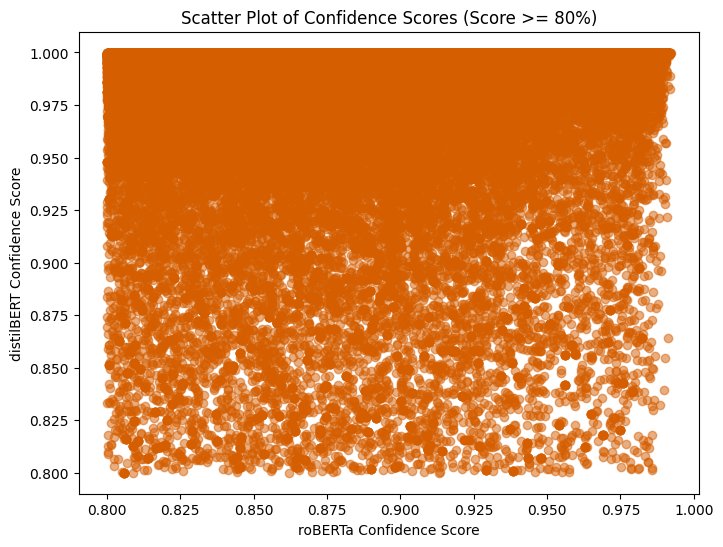

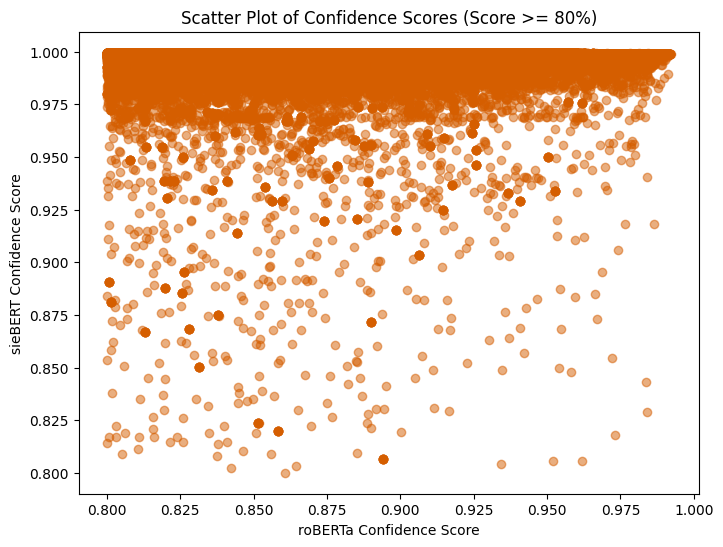

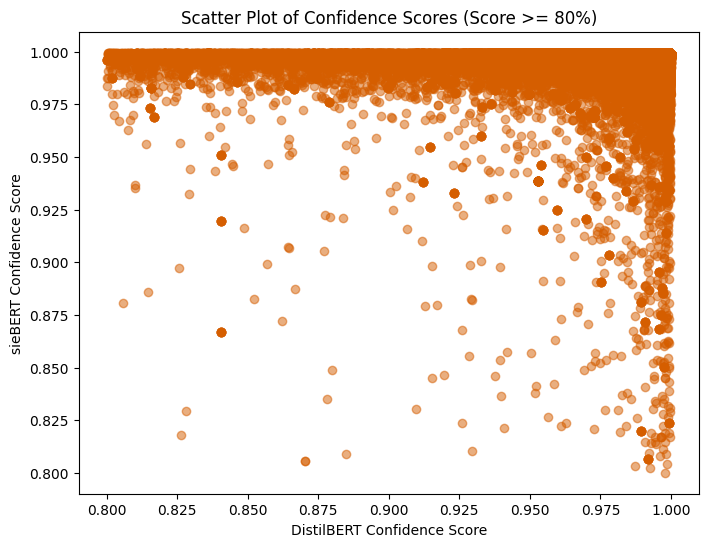

In [63]:
# Scatter plot for roBERTa vs DistilBERT
plt.figure(figsize=(8,6))
plt.scatter(merged_conf['sentiment_score_roberta'], merged_conf['sentiment_score_distilbert'], alpha=0.5)
plt.xlabel("roBERTa Confidence Score")
plt.ylabel("distilBERT Confidence Score")
plt.title("Scatter Plot of Confidence Scores (Score >= 80%)")
plt.show()

# Scatter plot for roBERTa vs sieBERT
plt.figure(figsize=(8,6))
plt.scatter(merged_conf['sentiment_score_roberta'], merged_conf['sentiment_score_sieb'], alpha=0.5)
plt.xlabel("roBERTa Confidence Score")
plt.ylabel("sieBERT Confidence Score")
plt.title("Scatter Plot of Confidence Scores (Score >= 80%)")
plt.show()

# Scatter plot for DistilBERT vs sieBERT
plt.figure(figsize=(8,6))
plt.scatter(merged_conf['sentiment_score_distilbert'], merged_conf['sentiment_score_sieb'], alpha=0.5)
plt.xlabel("DistilBERT Confidence Score")
plt.ylabel("sieBERT Confidence Score")
plt.title("Scatter Plot of Confidence Scores (Score >= 80%)")
plt.show()

#### **1. roBERTa vs. DistilBERT**:

**High density near DistilBERT ≈ 1.0:**

Many points line up along the top, meaning DistilBERT is often extremely confident (close to 1.0), while roBERTa’s confidence ranges from about 0.8 to 1.0.

**Lack of a diagonal trend:**

Because DistilBERT values are so frequently pegged near 1.0, you do not see a clear diagonal cluster. This aligns with the low Pearson correlation—there is no strong linear relationship between the two sets of confidence scores.

**Interpretation:**

DistilBERT appears to “max out” on confidence for these tweets (in the 0.8+ subset), whereas roBERTa is more varied in its high-confidence range. This can lead to a weak correlation: a tweet roBERTa calls 0.83 might be a tweet DistilBERT calls 0.98 or 1.0.

#### **2. roBERTa vs. sieBERT**

**Slightly more spread for both models:**

You can see roBERTa’s x-axis in 0.8–1.0, and sieBERT also spanning that same range on the y-axis, though there is a concentration near the top. It still looks “blob-like” rather than a tight diagonal line.

**Some grouping near (1.0, 1.0):**

There are definitely points in the top-right corner where both roBERTa and sieBERT are near 1.0. But there are also plenty of points where roBERTa might be near 1.0 and sieBERT is around 0.85 (and vice versa).

**Interpretation:**

Overall, roBERTa and sieBERT are also not in strong linear agreement. You’ll see individual tweets about which roBERTa is extremely confident, but sieBERT is somewhat less so, and vice versa. This visually corresponds to the small Pearson and moderate/low Spearman values.

#### **3. DistilBERT vs. sieBERT**

**Cluster at (x ≈ 1.0, y ranging from 0.8–1.0) and (x ranging 0.8–1.0, y ≈ 1.0):**

This “L-shaped” boundary (right edge and top edge) is formed because DistilBERT or sieBERT frequently hits 1.0 confidence while the other has a slightly lower, yet still 0.8+ confidence.

**Some partial diagonal shape near the top-right corner:**

There may be a mild diagonal cluster if you look closely at the portion of tweets for which both DistilBERT and sieBERT are around 0.9–1.0, consistent with the slightly higher Spearman correlation (0.2785) for this pair compared to the others.

**Interpretation:**

Of the three comparisons, DistilBERT and sieBERT exhibit the highest (though still not strong) monotonic correlation. DistilBERT often goes to 1.0, but sieBERT also does it more than roBERTa does, so there is a bit more overlap in their high-confidence extremes.

#### Temporal Trends Sentiment Analysis

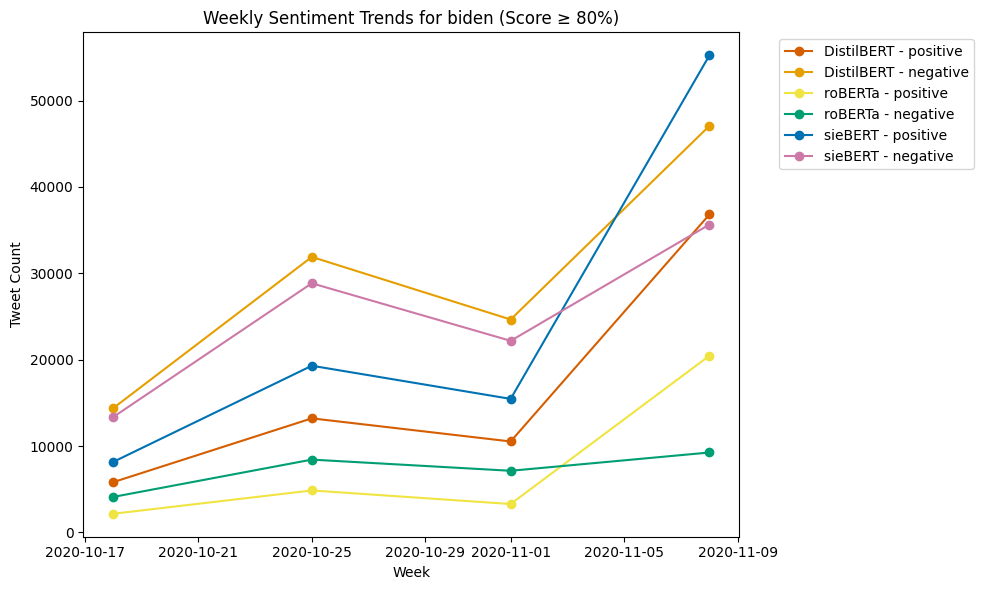

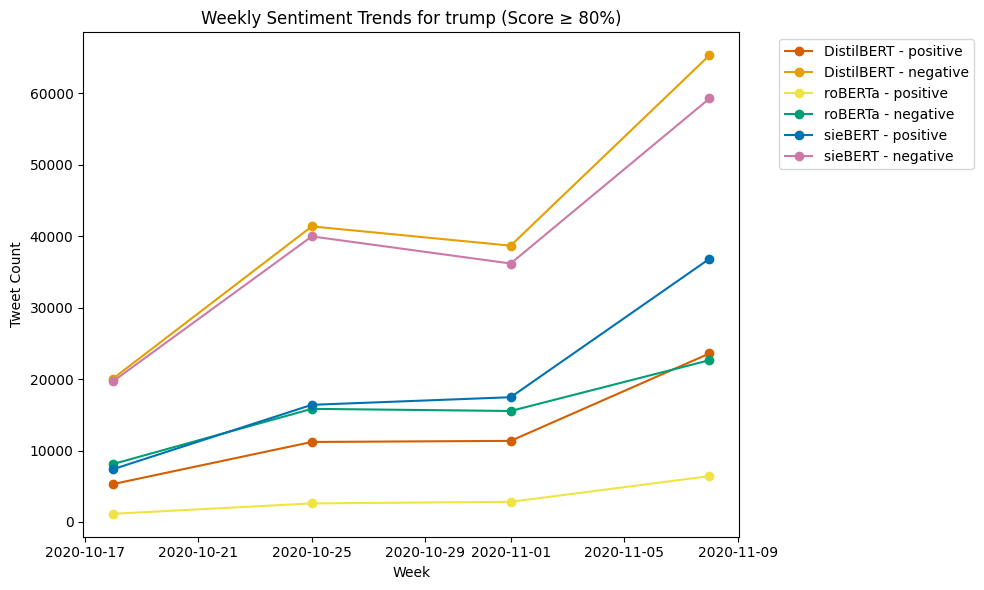

In [61]:
# Temporal Trends Sentiment Analysis
for df in [df_roberta, df_distilbert, df_sieb]:
    df.loc[:, 'created_at'] = pd.to_datetime(df['created_at'])

# Combine the filtered DataFrames
all_time_df = pd.concat([df_roberta, df_distilbert, df_sieb],
                        ignore_index=True)

# Group the data by week, candidate, model, and sentiment; count tweets
weekly_counts = all_time_df.groupby([pd.Grouper(key='created_at', freq='W'),
                                     'candidate', 'model', 'sentiment']) \
                           .size() \
                           .reset_index(name='count')

# Plot temporal trends for each candidate
# (each plot shows both sentiment types and all three models)
for candidate in weekly_counts['candidate'].unique():
    candidate_subset = weekly_counts[weekly_counts['candidate'] == candidate]

    plt.figure(figsize=(10,6))

    # Loop through each model and sentiment combination
    for model in candidate_subset['model'].unique():
        for sentiment in ['positive', 'negative']:
            subset = candidate_subset[(candidate_subset['model'] == model) & \
                                      (candidate_subset['sentiment'] == sentiment)]
            if not subset.empty:
                plt.plot(subset['created_at'], subset['count'], marker='o',
                         label=f"{model} - {sentiment}")

    plt.title(f"Weekly Sentiment Trends for {candidate} (Score ≥ 80%)")
    plt.xlabel("Week")
    plt.ylabel("Tweet Count")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

As is expected we see higher tweet counts as time approaches election day. However in Trump's case his negative tweets increase a lot more while Biden's positive tweets also increase.